In [1]:
from rnn_shuffle import *
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import warnings
warnings.filterwarnings('ignore')

In [2]:
root = 'texts/'

f = open(root + 'train.txt', 'r')
content = f.read()
print(len(content))
unique_chars = set(content)
unique_chars.add('λ')
chars_lst = sorted(list(unique_chars), key=str)
char_dict = {char:i for i, char in enumerate(chars_lst, 0)}
char_idxs = {i:char for i, char in enumerate(chars_lst, 0)}

379977


In [3]:
#1-hot-encoding where onehot[i] is the 1hotencoding of the ith character
length = len(chars_lst)
onehot = np.zeros((length, length))
for i, char in enumerate(chars_lst, 0):
    onehot[i, i] = 1

In [4]:
def prepare(sample):   
    return torch.LongTensor([[char_dict[i] for i in sample]])

In [5]:
def get_chunks(song):
    chunklst = []
    C = 100 #chunk size
    chunks = len(song) // C
    for idx in range(chunks):
        i = idx * C
        j = (idx+1) * C
        inp = prepare(song[i:j])
        tar = prepare(song[i+1:j+1])
        chunklst.append((inp, tar))
    return chunklst

In [6]:
temp = 1

In [7]:
def tensor_to_char(sample):
    pred_chars = torch.multinomial(F.softmax(sample.div(temp)), 1).view(-1)
    return ''.join(char_idxs[i.item()] for i in pred_chars.to('cpu'))

In [8]:
def to_char(sample):
    return char_idxs[sample.item()]
#     return ''.join(char_idxs[i.item()] for i in sample.to('cpu'))
#     return [char_idxs[i.item()] for i in sample.to('cpu')]

In [9]:
weight = torch.Tensor(onehot)

In [10]:
# embedding = nn.Embedding.from_pretrained(weight)
hidsz = 499
inpsz = 94
outsz = 94 # vocab size?
num_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pathdir = 'model_states/' + str(hidsz) + 'units'

In [11]:
net = RNnet(inpsz, hidsz, outsz, weight, num_layers).to(device)
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(net.parameters(), lr=0.001)
# capset = loader('cap.txt')
# capacaity = DataLoader(capset, batch_size=1, shuffle=True,
#                        num_workers=1, pin_memory=True)

In [12]:
trainset = loader(root + 'train.txt')

validset = loader(root + 'val.txt')

In [13]:
shuffle_dataset = True
random_seed= 42



tsize = len(trainset)
vsize = len(validset)
tidxs = list(range(tsize))
vidxs = list(range(vsize))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(tidxs)
    
    np.random.seed(random_seed)
    np.random.shuffle(vidxs)

# torch.manual_seed(random_seed)
tsampler = SubsetRandomSampler(tidxs)

# torch.manual_seed(random_seed)
vsampler = SubsetRandomSampler(vidxs)

In [14]:
train = DataLoader(trainset, batch_size=1,
                  sampler=tsampler)

valid = DataLoader(validset, batch_size=1,
                  sampler=vsampler)


In [15]:
states = None
epochs = 25
N = 50
stop = True #ESing
tloss = []
vloss = []
# models = []
best_loss = float('inf')


#resets the seed within generational runs but still sample
#songs still randomized within each epoch
torch.manual_seed(random_seed)

for itrs in range(epochs):
    
    epochloss = []
    #states = None
    
#     optimizer = adaptiveLR(optimizer, itrs)
    
    for i, song in enumerate(train, 0):
        song = song[0]
        trainloss = 0
        minibatchloss = 0
        xnloss = []
        states = None
        
        for inputs, targets in get_chunks(song):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs, states = net(inputs, states)
            targs = torch.squeeze(targets)
            print('Epoch [%d] minibatch [%d]\r' % (itrs+1, i), end="")

            loss = criterion(outputs, targs)
            loss.backward()
            optimizer.step()

            trainloss += loss.item()      
            xnloss.append(loss.item())

            if i % N == 49:
#                 trainloss /= N
                #Print the loss averaged over the last N mini-batches
                print('\tEpoch %d, running %d loss: %.3f\r' % (1,i+1, trainloss), end="")
                trainloss = 0

        song_loss = np.average(xnloss)
        epochloss.append(song_loss)
    
    eploss = np.average(epochloss)
                
    print('Epoch [%d] train loss is (%.3f)' % (itrs+1, eploss)) 
    tloss.append(eploss)
    
    
    epochloss = []
    songout = '<'
    
    with torch.no_grad():
        for i, song in enumerate(valid, 0):
            song = song[0]
            validloss = 0
            minibatchloss = 0
            xncost = []
            states = None
            for inputs, targets in get_chunks(song):
            
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs, states = net(inputs, states)

                targs = torch.squeeze(targets)
    #             print('Epoch [%d] minibatch [%d]\r' % (itrs+1, i), end="")
                loss = criterion(outputs, targs).item()

                validloss += loss

                xncost.append(loss)

                if i % N == 49:
                    validloss /= N
                    #Print the loss averaged over the last N mini-batches
                    print('\tEpoch %d, valid %d loss: %.3f\r' % (1,i+1, validloss), end="")
                    validloss = 0
                if i == 0:
                    songout += tensor_to_char(outputs)
            
            eploss = np.average(xncost)
            epochloss.append(eploss)
    
        ep_loss = np.average(epochloss).round(4)
        print('Epoch [%d] valid loss is (%.4f)' % (itrs+1, ep_loss)) 

        #can also do itrs (epochs) > 2?
        if len(vloss) < 2:
            vloss.append(ep_loss)
#             models.append(net.state_dict())
        elif vloss[-2] <= vloss[-1] <= ep_loss:
            vloss.append(ep_loss)
#             models.append(net.state_dict())
            if stop:
                print("EARLY STOPPED AT EPOCH: ", itrs + 1)
                print("models[-2] has the lowest valid error?")
                break
        else:
            vloss.append(ep_loss)
#             models.append(net.state_dict())
    
    if itrs % 3 == 0:
        print('---------------------------------')
        print('GENERATED SONG AT EPOCH [{}]'.format(itrs+1))
        print(songout)
        print('---------------------------------')
    
#     path = 'model_states/states_' + 'ep' + str(itrs+1) + '.pt'
    #if we got a better loss, save the model_state_dict()
    if vloss[-1] < best_loss:
        path = pathdir +  '.pt'
        torch.save(net.state_dict(), path)
        print('new best loss')
        best_loss = vloss[-1]

    print()

Epoch [1] train loss is (2.119)45
Epoch [1] valid loss is (1.7377)
---------------------------------
GENERATED SONG AT EPOCH [1]
<start>
X:11T:6e rai  ov Ca nte ,dl raa-sn'ymc:BoanHutoa
S:Corc  Gdanjanss
yarrien bntFagt os fh  naew eeorttu She ter yeemeski
::8ersln oima t an oavg,iHe
MirstensHeyraise
w60Z:Jrrd uleosuat 
TaeliRdcolnHoasfdzeDo toilenToaiea'yR:Noa .netolyw 
T:Td:hn-harn2-nl-66M:6|
K:G
oo
|B fr|a ~2gb fa  caA2|c|d33Ad e3ccA|AF:A|
|3cf eccc3(cA A3=cc B3BAG bDG|ddBc3AD DF |c2GBgGB||
c: 2B Bd2 BBG||(eff d3fd|"a\eatD~AddanoWd duAaandcs
 tAetnass'\n_:14ff ]ece e2g!> fte||f2edf,G^B: "BdBdgD/ FG|:|dF2dg eff|dgea cudfBB|A3Bcc fgBGA |>F||AD2cc gd e3cdF B3DGd B32AG DG||DDA2BFB GD A3AGF|AD||
|:varoations
B' c> d/fdfa||1edd3od c|Ce|G|~4cf3ccd EB:||cBd B Bggc3FdA|(2Gd3D/G||F:DeGGDdB  B2F2 AFG|
<:<FA Ee cAGed|gacg=b}f3/d edas|f6pfgffe Af ||aVBd  afgf|(3 )d egBdd4||cdc :3"dF E> ||f2edG2 afg||f2ed3ffd |e> : a|ee3dcG/AFB^|BG2GG df dBcBBF
GG:FGdG|A -Gλ|EBdB/ 
2 |BA~(f/ G|F |
<end>
λλλλλλλλλ

In [16]:
len(vloss)

7

In [17]:
minloss = np.argmin(vloss)
minloss

4

In [18]:
loss_str = str(int((vloss[minloss] - 1).round(4) * 1000))
loss_str

'312'

In [19]:
vloss

[1.7377, 1.5062, 1.4049, 1.3627, 1.3128, 1.3182, 1.3221]

In [ ]:
len(tloss), len(vloss), len(models)

In [ ]:
print(vloss)

In [ ]:
path

In [ ]:
​

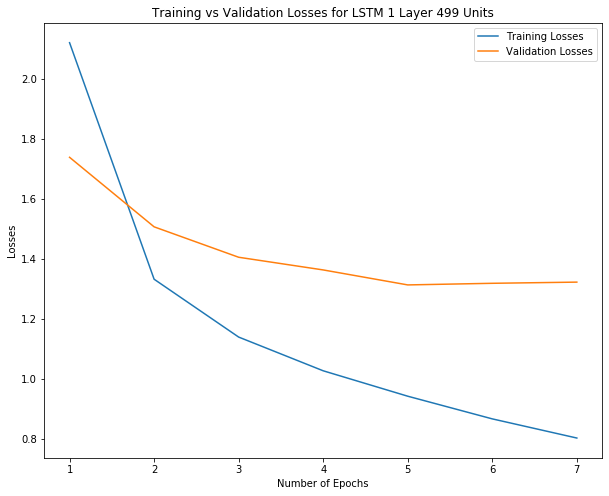

In [20]:
# torch.argmax(F.softmax(outputs.div(temp), dim=1), 1).sum()
tloss, vloss
graph_title = 'Training vs Validation Losses for LSTM 1 Layer ' + str(hidsz) + ' Units'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(tloss) + 1), tloss, label='Training Losses')
ax.plot(np.arange(1, len(vloss) + 1), vloss, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend() #loc=4)
fig.savefig('graphs/' + str(hidsz) + 'units_vloss' + loss_str + '.png')

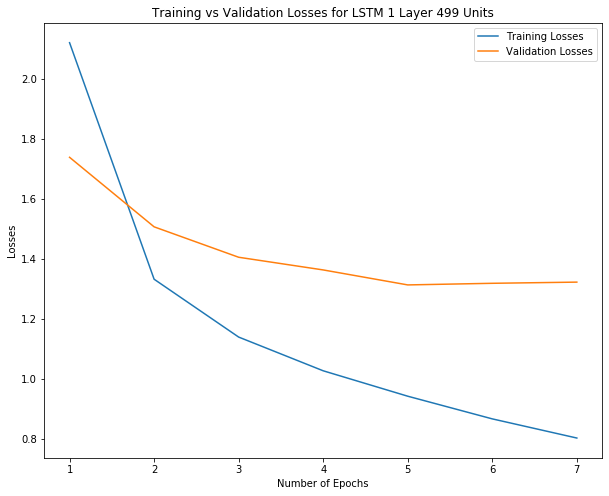

In [21]:
fig

In [ ]:
test20 = capset[1][:50]
test20

In [26]:
#capset[1][:60]

prime_chars = open(root + 'prime.txt').read()
prime_chars

'<start>\nX:1\nT:Les  '

In [52]:
len(prime_chars)

38

In [ ]:
net.eval()
input_char = '<' # make longer if not doing it right '<start>'
input_string = '<start>\nX:'
temp = 0.7
inp_str = input_string
inputs = prepare(inp_str).to(device)
initial_output, initial_state = net(inputs, None)

pls_work = pls_work = torch.multinomial(F.softmax(initial_output.div(temp)), 1)
lastchar = to_char(pls_work[-1])

inp_str += lastchar
print(inp_str)
print()

# argmax
# multiple
while '<end>' not in inp_str:
# for _ in range(1000):
    inputs = prepare(inp_str).to(device)
    output, initial_state = net(inputs, None)
    pls_work = pls_work = torch.multinomial(F.softmax(output.div(temp)), 1)
    lastchar = to_char(pls_work[-1])
    inp_str += lastchar

print(inp_str)

In [37]:
#capset[1][:60]

prime_chars = open(root + 'prime.txt').read()
prime_chars, len(prime_chars)

('<start>\nX:1\nT:Co', 16)

In [30]:
#print(inp_str)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bestmodelpath = pathdir + '.pt'

makesong_net = RNnet(inpsz, hidsz, outsz, weight, num_layers)

makesong_net.load_state_dict(torch.load(bestmodelpath))
makesong_net = makesong_net.to(device)
makesong_net.eval()

RNnet(
  (char_embeddings): Embedding(94, 94)
  (lstm): LSTM(94, 499)
  (hidden2out): Linear(in_features=499, out_features=94, bias=True)
)

In [104]:
max_str = prime_chars

inputs = prepare(max_str).to(device)
initial_output, initial_state = makesong_net(inputs, None)

pls_work = torch.argmax(F.softmax(initial_output), 1)
lastchar = to_char(pls_work[-1])

max_str += lastchar
print(max_str)
print()

# argmax
# multiple
i = 1
while '<end>' not in max_str:
# for _ in range(1000):
    inputs = prepare(max_str).to(device)
    output, initial_state = makesong_net(inputs, None)
    pls_work = torch.argmax(F.softmax(output), 1)
    lastchar = to_char(pls_work[-1])
    max_str += lastchar
    i += 1
    if 'λ' in max_str:
        break
    if i == 1000:
        break

print(max_str)

<start>
X:1
T:Fara



KeyboardInterrupt: 

In [46]:
print(max_str)

<start>
X:1
T:Correst Coureele
R:Branle
A:Provence
C:Trad.
R:Marche
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-03-23
Z:Pour toute observation mailto:galouvielle@free.fr
M:C
L:1/8
K:Bb
V:1
z |: B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B2B B2B | B


In [83]:
print(max_str)

510

In [101]:
input_char = '<' # make longer if not doing it right '<start>'
input_string = '<start>\nX:'
temp = 0.7
inp_str = prime_chars

seed = int(torch.rand(1)[0].item() * 1e3)

torch.manual_seed(seed)
print(seed)

inputs = prepare(inp_str).to(device)
initial_output, initial_state = makesong_net(inputs, None)

pls_work = torch.multinomial(F.softmax(initial_output.div(temp)), 1)
lastchar = to_char(pls_work[-1])

inp_str += lastchar
print(inp_str)
print()

# argmax
# multiple
while '<end>' not in inp_str:
# for _ in range(1000):
    inputs = prepare(inp_str).to(device)
    output, initial_state = makesong_net(inputs, None)
    pls_work = torch.multinomial(F.softmax(output.div(temp)), 1)
    lastchar = to_char(pls_work[-1])
    inp_str += lastchar
    
    if 'λ' in inp_str:
        break

print(inp_str)


355
<start>
X:1
T:Fara

<start>
X:1
T:Farandole de Bourreg ?
S:Carnet du tambourinaire Ginas (1924)
O:France
A:Provence
R:Bourree
M:2/4
L:1/8
K:F
t a a fa/e/ | dc d2 AF | B2 BA BG GA | cB cd ed | ef ed ce :|
<end>


In [84]:
len(inp_str)

510

In [95]:
songpath = 'songs/t' + str(0) + 'song2.txt'
f = open(songpath, "w")
f.write(inp_str)
f.close()

In [29]:
print(inp_str)

<start>
X:54
T:Gridiqy
T:Bonpotes Qfeelot"C
C:Luls. ^Divarg(Sdined'AHe,Fl Risddien \'u?Reghon afEruw.
H:-crlatkyy Dava deed2s"QHxwowcane lin d.so nr\sel.,C3
C:M. FM6id:qufide
K1 ChaiAA@ne"J]_fe ^(7.d) zed, T7gfgd f2>f2e+b"Tuae'"L ~fl}c3' =1(8:|
czGF Gcd |:(3D(CxC+)}ABAnde!D| {E2{A_D B^ c~=B2] dOW|A[Q(1</2sb inAPJuyplet:lidzuGoqu.en vro
Eccdaralca=Agul/(g/agfelv(1)M^)=Gac4B4z|
HFd,ubly,8 Bys>>F,>E f><E>>G8|{a!DiEC.D	CE,6M[G5]B Og ak+b>-~'v5anwet/ :|x8:36
Q:C]fvG,-4LC_OfUy4T7b"DmC5}CCEw.G8:|: .A2cG CGF^A>(Bfg (v=a/) OAF)^DMe|A2B>2ce +Waeuul beps.rausfqurqu_' dlfy'_FA-GVamMK4Is]fat{a'Sneh''sstte/c
ZTVurd oll'ash
G2F|d3:|=7~E2QA.PMa/L
M:<|abd? Bdd |16B6 :|f d2_ag |  ~f3lab
a[d''7' b/2FK|Ic !bricate_ njw0s
P:"6?<Enmin:
[v4F3/3/ GABcLd2Gc2BE|
K:G (?o =8hoZdioan"\1y-c	G2AB,CC o-.D_+S EC,^F,</2CG3|{G
B,2^FGG,B,c4,|ScA
Aq.d.A. c>AH|HAABa fe_c=c.A <GJ5:: _As2d2]2: cotq=222.u
B>A/G>f|e{ac/gf):| [Gg ggf2+g'<saa	|
Wz4c	62 zA 4 |[2A4 B8|
Q:4/4=)1^f7z[c2][Fd+E] kdh[dg.f Leiv2o!=:: L|./2z/2f/2f]B9!r:!

In [99]:
prime_chars = open(root + 'prime.txt').read()
prime_chars

'<start>\nX:1\nT:Far'

In [100]:
len(prime_chars)

17

In [12]:
len(testset)

166

In [22]:

loadpath = pathdir + '.pt'
savepath = pathdir + loss_str + '.pt'

testnet = RNnet(inpsz, hidsz, outsz, weight, num_layers)

testnet.load_state_dict(torch.load(loadpath))
testnet = testnet.to(device)
torch.save(testnet.state_dict(), savepath)

criterion = nn.CrossEntropyLoss()


In [23]:
testset = loader(root + 'test.txt')
test = DataLoader(testset, batch_size=1)
len(testset)

166

In [24]:
testloss = []
songout = '<'

testnet.eval()

for i, song in enumerate(test, 0):
    song = song[0]
    songloss = []
    states = None
    
    for inputs, targets in get_chunks(song):

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs, states = testnet(inputs, states)
        targs = torch.squeeze(targets)
        loss = criterion(outputs, targs).item()

#         testloss += loss
        songloss.append(loss)


    avgloss = np.average(songloss)
    testloss.append(avgloss)

test_loss = np.average(testloss)

In [25]:
test_loss

1.2635578162004601